In [1]:
import mne
import yasa
import numpy as np
import pandas as pd
import antropy as ant
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

In [2]:
# Load EEG data
f = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz')
data, ch_names = f['data'], f['chan']
sf = 100.
times = np.arange(data.size) / sf

# Keep only Cz
data = data[0, :]
print(data.shape, np.round(data[0:5], 3))

(2161058,) [15.797 22.307 39.922 25.657 27.094]


In [3]:
# Load the hypnogram data
hypno = np.loadtxt('data_full_6hrs_100Hz_hypno_30s.txt').astype(int)
print(hypno.shape, 'Unique values =', np.unique(hypno))
hypno = yasa.hypno_upsample_to_data(hypno, 1/30, data, sf)

23-Feb-22 18:41:30 | WARNING | Hypnogram is SHORTER than data by 10.58 seconds. Padding hypnogram with last value to match data.size.


(720,) Unique values = [0 1 2 3 4]


In [4]:
# Bandpass filter
data = mne.filter.filter_data(data.astype('float64'), sf, 0.5, 30, verbose=0)

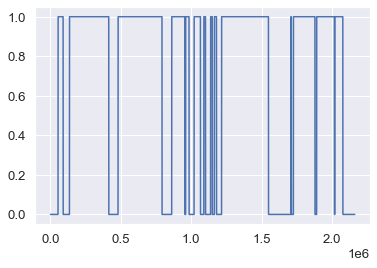

In [5]:
include = (2, 3)
mask = np.in1d(hypno, include).astype(int)
plt.plot(mask);

In [6]:
def find_runs(x):
    """Find runs of consecutive items in an array.

    From https://gist.github.com/alimanfoo/c5977e87111abe8127453b21204c1065
    """
    n = x.shape[0]
    # Find run starts
    loc_run_start = np.empty(n, dtype=bool)
    loc_run_start[0] = True
    np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
    run_starts = np.nonzero(loc_run_start)[0]
    # Find run values
    run_values = x[loc_run_start]
    # Find run lengths
    run_lengths = np.diff(np.append(run_starts, n))
    return pd.DataFrame({'values': run_values, 'start': run_starts, 'length': run_lengths})

In [7]:
# Calculate NREM periods (>5 min consecutive)
n_samples_thr = int(pd.Timedelta("10min").seconds * sf)

# This show the onset and duration (in samples) of all the NREM epochs that are > 5 min
epochs = find_runs(mask).query("values == 1 and length > @n_samples_thr").reset_index(drop=True)
epochs

,values,start,length
0,1,135000,279000
1,1,480000,312000
2,1,861000,93000
3,1,1215000,333000
4,1,1725000,153000
5,1,1890000,126000


In [8]:
# Calculate the onset time (relative to sleep onset) of each NREM period
# Sleep onset is defined as the first epoch of N2 or N3 sleep
idx_onset = np.nonzero(np.in1d(hypno, (2, 3)))[0][0]
epochs['time_onset_hrs'] = (epochs['start'] - idx_onset) / sf / 3600
epochs['length_hrs'] = epochs['length'] / 2 / sf / 3600
epochs['time_mid_hrs'] = epochs['time_onset_hrs'] + epochs['length_hrs']
epochs

,values,start,length,time_onset_hrs,length_hrs,time_mid_hrs
0,1,135000,279000,0.225000,0.387500,0.612500
1,1,480000,312000,1.183333,0.433333,1.616667
2,1,861000,93000,2.241667,0.129167,2.370833
3,1,1215000,333000,3.225000,0.462500,3.687500
4,1,1725000,153000,4.641667,0.212500,4.854167
5,1,1890000,126000,5.100000,0.175000,5.275000


In [9]:
# Calculate continuous mask with unique value for each epoch
mask_epoch = np.zeros_like(mask, dtype=int)
for i, row in epochs.iterrows():
    start = int(row['start'])
    end = int(row['start']+row['length']+1)
    mask_epoch[start:end] = i + 1

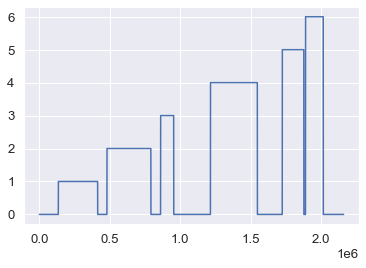

In [10]:
plt.plot(mask_epoch);

In [11]:
# Calculate SWA power in each period, for each channel
nperseg = int(4 * sf)
freq_swa = (0.5, 4)
freq_broad = (0.5, 30)
win_sec = 4
kwargs_welch = dict(average='median', window='hamming')

bp = yasa.bandpower(
    data, sf, hypno=mask_epoch, include=list(range(1, max(mask_epoch) + 1)), 
    win_sec=win_sec, relative=False, bandpass=False, 
    bands=[(freq_swa[0], freq_swa[1], "SWA"), (freq_broad[0], freq_broad[1], "Broad")], 
    kwargs_welch=kwargs_welch)

bp['SWA_rel'] = bp['SWA'] / bp['TotalAbsPow']
bp['SWA_pct'] = 100 * (bp['SWA'] - bp['SWA'].mean()) / bp['SWA'].mean()

bp

,,SWA,Broad,TotalAbsPow,FreqRes,Relative,SWA_rel,SWA_pct
Stage,Chan,,,,,,,
1,CHAN000,668.173418,759.297013,759.297013,0.25,False,0.879990,18.212024
2,CHAN000,1174.061420,1258.679770,1258.679770,0.25,False,0.932772,107.712808
3,CHAN000,244.251907,300.108848,300.108848,0.25,False,0.813878,-56.787397
4,CHAN000,927.758286,1005.541157,1005.541157,0.25,False,0.922646,64.137306
5,CHAN000,162.065672,211.257012,211.257012,0.25,False,0.767149,-71.327637
6,CHAN000,215.087541,279.616880,279.616880,0.25,False,0.769222,-61.947104


In [12]:
# Calculate exponential decline
# https://doi.org/10.1093/sleep/33.4.491
# https://bmcneurosci.biomedcentral.com/articles/10.1186/1471-2202-12-84#Sec8
# S(t) = (S_sleeponset - lower_asym) * exp(-t / slope) + lower_asym
# - The time t starts at zero at sleep onset.
# - Data were normalized within each subject with mean SWA across all derivations
# - Therefore, SWA and LA are expressed in percentage.
# Thus, τd was restricted to a range of 0 to 4 h. Additionally, LA was forced to be larger or equal zero.

from scipy.stats import zscore
from scipy.optimize import curve_fit

def _fit_exp_decay(t, asym, intercept, slope):
    """Exponential decay equation"""
    return (intercept - asym) * np.exp(- t / slope) + asym

xdata = epochs['time_onset_hrs'].to_numpy()
ydata = bp['SWA_rel']

# Asymptote must be between 0 and 1 if evaluating relative power
# Intercept must be between 0 and 1 if evaluating relative power
# Slope must be between 

popt, _ = curve_fit(_fit_exp_decay, xdata, ydata, 
                    bounds=((0, 0, 0), (1, 1, 4)))

popt

array([0.74709014, 0.92988017, 4.        ])

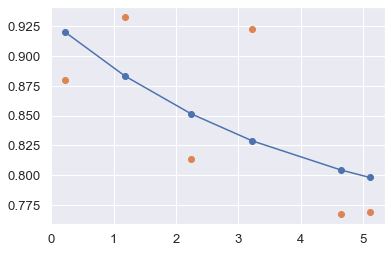

In [13]:
plt.plot(xdata, _fit_exp_decay(xdata, *popt), marker="o");
plt.plot(xdata, ydata, linewidth=0, marker="o");